# Customer Segmentation & CLV Prediction

## Project Overview

This project focuses on customer segmentation and prediction of **Customer Lifetime Value (CLV)** using transactional data. It leverages **RFM analysis**, **predictive modeling**, and **data visualization** to help businesses understand customer behavior and take data-driven decisions to improve retention and value.

## Objectives

- Segment customers based on Recency, Frequency, and Monetary value (RFM).
- Predict Customer Lifetime Value (CLV) using machine learning.
- Classify customers into behavioral classes (High, Medium, Low Frequency).
- Generate actionable insights to improve marketing strategy and customer retention.

## Dataset

### Online Retail.csv

- Contains transactions from a UK-based online retailer from 2010–2011.
- Features include: `InvoiceNo`, `StockCode`, `Description`, `Quantity`, `InvoiceDate`, `UnitPrice`, `CustomerID`, and `Country`.

### classified_customers.csv (Generated)

Contains customer-wise aggregated data with predicted values and assigned segments:

| Column                          | Description                                   |
|--------------------------------|-----------------------------------------------|
| CustomerID                     | Unique ID of the customer                     |
| Recency                        | Days since last purchase                      |
| Frequency                      | Count of unique purchase occasions            |
| NumInvoices                    | Total invoices per customer                   |
| Monetary                       | Total revenue per customer                    |
| AvgOrderValue                  | Average value per transaction                 |
| AvgDaysBetweenPurchases        | Actual average days between purchases         |
| PredictedAvgDaysBetweenPurchases | ML model prediction                        |
| CustomerClass                  | Segmented class: High, Medium, or Low Frequency |

## Key Features & Workflow

### 1. Data Preprocessing

- Removed null or invalid `CustomerID` entries.
- Filtered out cancelled transactions.
- Handled outliers and calculated transaction value.

### 2. RFM Feature Engineering

- **Recency**: Days since last purchase.
- **Frequency**: Number of repeat purchases.
- **Monetary**: Total spending.

### 3. CLV Prediction

- Built a Random Forest Regressor to predict average days between purchases.
- Used Frequency, Monetary, Recency as features.
- Evaluated model using RMSE and prediction visualizations.

### 4. Customer Segmentation

- Applied custom rule-based classifier on predicted purchase frequency:
  - High Frequency: AvgDays < 30 days
  - Medium Frequency: AvgDays between 30–90 days
  - Low Frequency: AvgDays > 90 days

### 5. Visualization & Insights

- Bar plots, scatter plots, and histograms to analyze distribution and clustering.
- CLV prediction trends and customer class breakdowns.

## Tech Stack

- Python
- pandas, numpy
- matplotlib, seaborn
- scikit-learn

## Sample Output (classified_customers.csv)

```
CustomerID,Recency,Frequency,Monetary,...,CustomerClass
12347.0,1,7,4310.0,...,High Frequency
12363.0,109,2,552.0,...,Low Frequency
12410.0,300,3,681.07,...,Low Frequency
...
```

## Model Performance

- Model: Random Forest Regressor
- Evaluation Metric: RMSE (Root Mean Squared Error)
- Delivered strong predictive accuracy on purchase interval estimation.

## How to Run

1. Clone this repository or open the notebook in Jupyter/Colab.
2. Place the `Online Retail.csv` file in your working directory.
3. Run `Mlproject.ipynb` to:
   - Preprocess data
   - Train the model
   - Generate the output file `classified_customers.csv`

## Business Use-Cases

- **Customer Retention**: Target High and Medium Frequency users with personalized campaigns.
- **Resource Allocation**: Prioritize support/sales for high CLV segments.
- **Churn Prediction**: Identify customers with increasing inactivity patterns.

## Files Included

- `Mlproject.ipynb` – Jupyter notebook containing the full pipeline
- `Online Retail.csv` – Source dataset
- `classified_customers.csv` – Final output with CLV predictions and segmentation

## Credits

Dataset: [UCI Online Retail Dataset](https://archive.ics.uci.edu/ml/datasets/Online+Retail)  
Project by: *Sailendra Kumar*


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib

# Load data
data = pd.read_csv('Online Retail.csv',encoding='ISO-8859-1')

# Handle missing values
data.dropna(subset=['CustomerID'], inplace=True)

# Feature Engineering
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'],format='%d-%m-%Y %H:%M')
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

# Aggregate data by customer
customer_data = data.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (data['InvoiceDate'].max() - x.max()).days, 'nunique'],
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

customer_data.columns = ['CustomerID', 'Recency', 'Frequency', 'NumInvoices', 'Monetary']
customer_data['Recency'] = customer_data['Recency'].astype(int)
customer_data['AvgOrderValue'] = customer_data['Monetary'] / customer_data['NumInvoices']
customer_data['AvgDaysBetweenPurchases'] = customer_data['Recency'] / (customer_data['Frequency'] - 1)
customer_data.fillna(0, inplace=True)
customer_data.replace([np.inf, -np.inf], np.nan, inplace=True)


customer_data.dropna(subset=['AvgDaysBetweenPurchases'], inplace=True)

# Train-Test Split
X = customer_data.drop(['AvgDaysBetweenPurchases', 'Monetary'], axis=1)
y = customer_data['AvgDaysBetweenPurchases']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

# Save model
joblib.dump(model, 'clv_model.pkl')

# Load model and make prediction
model = joblib.load('clv_model.pkl')
sample_data = X_test.iloc[0:1]
sample_prediction = model.predict(sample_data)
print(f'Sample Prediction: {sample_prediction}')
customer_data['PredictedAvgDaysBetweenPurchases']=model.predict(X)


RMSE: 1.6226768463549432
Sample Prediction: [5.00333333]


In [ ]:


def classify_customer(avg_days):
    if avg_days < 30:
        return 'High Frequency'
    elif avg_days < 90:
        return 'Medium Frequency'
    else:
        return 'Low Frequency'

customer_data['CustomerClass'] = customer_data['PredictedAvgDaysBetweenPurchases'].apply(classify_customer)

# Save the output to a CSV file
customer_data.to_csv('classified_customers.csv', index=False)

print('Classified customer data saved to classified_customers.csv')


Classified customer data saved to classified_customers.csv


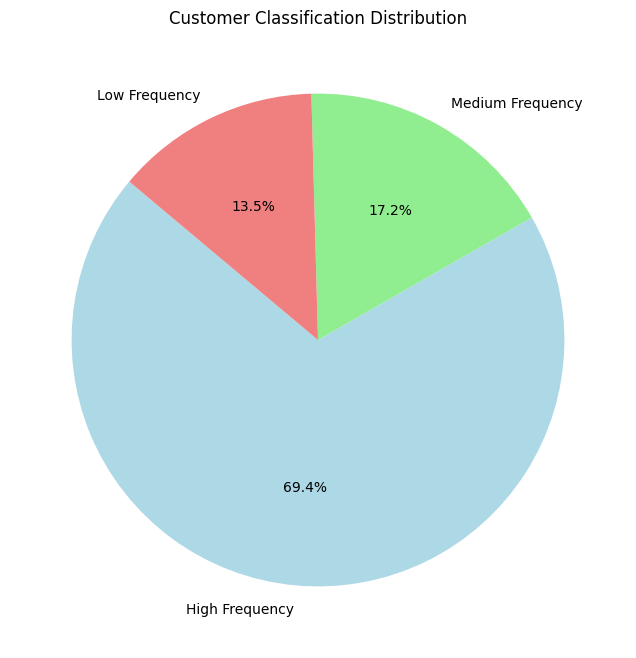

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the classified customer data
classified_data = pd.read_csv('classified_customers.csv')

# Count the number of customers in each class
class_counts = classified_data['CustomerClass'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Customer Classification Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()



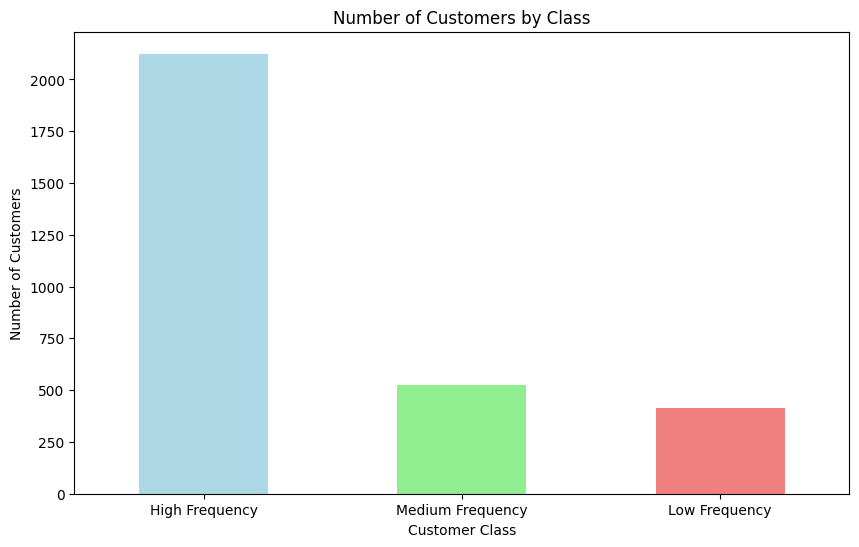

In [ ]:
# Plot a bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Number of Customers by Class')
plt.xlabel('Customer Class')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()
